In [634]:
import numpy as np
from keras.layers import Layer, Concatenate, Input, Dense, Multiply, Add, RepeatVector, Lambda, BatchNormalization, Dropout, LayerNormalization
import keras.backend as K
from keras.models import load_model, Model
from keras.metrics import CategoricalAccuracy
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import custom_object_scope
from keras.losses import CategoricalCrossentropy, MeanSquaredError
from keras.optimizers import Adam, Adadelta, Adagrad, Adamax
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay, ExponentialDecay
import json
from sklearn.model_selection import train_test_split

In [635]:
model_dir = 'model'
tanh_layer_size = 512
q_input_size = 768
i_input_size = 512
output_size = 2327
regions = 15

In [636]:
class QGAttention(Layer):
    def __init__(self, tanh_layer_size):
        super(QGAttention, self).__init__()
        self.tanh_layer_size = tanh_layer_size
 
    def build(self,input_shape):
        self.W1 = self.add_weight(name='attention_weight', shape=(input_shape[0][2], self.tanh_layer_size), 
                               initializer='random_normal', trainable=True)
        self.W2 = self.add_weight(name='attention_weight2', shape=(self.tanh_layer_size, 1), 
                               initializer='random_normal', trainable=True)
        #self.b=self.add_weight(name='attention_bias', shape=(1, 32), 
        #                       initializer='zeros', trainable=True)        
        super(QGAttention, self).build(input_shape)
 
    def get_config(self):
        config = super().get_config()
        config.update({
            "tanh_layer_size": self.tanh_layer_size,
        })
        return config
    
    # x = [batch_size, vector_length, regions]
    def call(self,input):
        x = input[0]
        regions = input[1]
        #tanh layer
        e = K.tanh(K.dot(x, self.W1))
        #linear layer
        #print('e: ', e)
        e = K.dot(e, self.W2)
        #print('e: ', e)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        #print('e: ', e)
        # Compute the weights
        alpha = K.softmax(e)
        #print('alpha: ', alpha)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        #print('alpha: ', alpha)
        # Compute the context vector
        context = regions * alpha
        #print('context: ', context)
        context = K.sum(context, axis=1)
        #print('context: ', context)
        return context

In [637]:
# https://visualqa.org/static/img/equation.png
def vqa_metric_single(y_true, y_pred):
    max_index = y_pred.index(max(y_pred))
    pred = [1 if i == max_index else 0 for i, _ in enumerate(y_pred)]
    times_answered = y_true.count(pred)
    score = min(times_answered/3, 1)
    return score

def vqa_metric(y_true, y_pred):
    scores = []
    for i, _ in enumerate(y_pred):
        scores.append(vqa_metric_single(y_true[i], y_pred[i].tolist()))
    return sum(scores) / len(scores)

In [638]:
@tf.function
def cond(inp):
    x = inp[0]
    y = inp[1]
    return tf.cond(tf.math.count_nonzero(x) == 0, lambda: tf.zeros(tf.shape(y)), lambda: tf.ones(tf.shape(y)))

def get_model(max_regions, q_input_size, r_input_size, tanh_layer_size):
    # output = 15x512
    r_inputs = Input(shape=(max_regions, r_input_size))
    # output = 15x512
#     rn_inputs = LayerNormalization()(r_inputs)
    # output = 768
    q_inputs = Input(shape=(q_input_size))
    # output = 768
#     qn_inputs = LayerNormalization()(q_inputs)
    # output = 15x768
    q_repeated_without_zeros = RepeatVector(max_regions)(q_inputs)
    # output = 15x768
    q_repeated_inputs = Lambda(cond)((r_inputs, q_repeated_without_zeros))
    # output = 15x1280
    attn_inputs = Concatenate()([r_inputs, q_repeated_inputs])
    # output = 512
    weighted_regions = QGAttention(tanh_layer_size)([attn_inputs, r_inputs])
    # output = 512
    tanh_question = Dense(512, activation='tanh')(q_inputs)
    # output = 512
    tanh_regions = Dense(512, activation='tanh')(weighted_regions)
    # output = 512
    region_question = Multiply()([tanh_question, tanh_regions])
    # output = 512
    region_nonlinear = Dense(512, activation='tanh')(region_question)
    # output = 512
    region_dropout = Dropout(0.5)(region_nonlinear)
    # output = 768
    question_nonlinear = Dense(768, activation='tanh')(region_question)
    # output = 768
    question_dropout = Dropout(0.5)(question_nonlinear)
    # output = 2327
    region_linear = Dense(2327)(region_dropout)
    # output = 2327
    question_linear = Dense(2327)(question_dropout)
    # output = 2327
    region_question_sum = Add()([region_linear, question_linear])
    # output = 2327
    outputs = Dense(2327, activation='sigmoid')(region_question_sum)

    model = Model(inputs=[r_inputs, q_inputs], outputs=outputs)
    
#     lr_schedule = ExponentialDecay(
#         initial_learning_rate=0.01,
#         decay_steps=500,
#         decay_rate=0.5
#     )

    lr_schedule = PiecewiseConstantDecay([500, 1000, 20000], [0.01, 0.005, 0.001, 0.00001])
    
    model.compile(
        optimizer=Adadelta(), 
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()]
    )
    return model

In [639]:
def train(x_train, y_train, x_val, y_val):
    model = get_model(regions, q_input_size, i_input_size, tanh_layer_size)
    print(model.summary())
    
    es = EarlyStopping(monitor='val_categorical_accuracy', 
                       mode='max', 
#                        min_delta=0.5, 
                       patience=50)
    mc = ModelCheckpoint('model/best_model.h5', 
                         monitor='val_categorical_accuracy', 
                         mode='max', 
                         save_best_only=True,
                         save_weights_only=True)
    
    history = model.fit(x_train, y_train, 
                        verbose=2, 
                        validation_data=(x_val, y_val), 
                        epochs=1000, 
                        callbacks=[es, mc],
                        batch_size=100
                       )
    try:
        model.load_weights('model/best_model.h5')
        _, old_acc = evaluate(x_val, y_val)
        _, new_acc = model.evaluate(x_val, y_val)
        if new_acc > old_acc:
            model.save(model_dir)
    except Exception:
        model.save(model_dir)
    return history

def train2(x_train, y_train, epochs, model_dir):
    model = get_model(regions, q_input_size, i_input_size, tanh_layer_size)
    print(model.summary())
    
    history = model.fit(x_train, y_train, 
                        verbose=2, 
                        epochs=epochs, 
                        batch_size=100
                       )
    model.save(model_dir)
    return history

In [640]:
def predict(x, model_dir):
    model = load_model(model_dir, custom_objects={'cond': cond})
    return model.predict(x)

In [641]:
def evaluate(x, y, model_dir):
    model = load_model(model_dir, custom_objects={'cond': cond})
    return model.evaluate(x, y)

In [642]:
def get_image_regions(string):
    result = str2fvs(string)
    result = result[:regions]
    current_len = len(result)
    for _ in range(0, regions-current_len):
        result.append([0]*i_input_size)
    return result

def str2fvs(string):
    fvs = []
    for strfv in string.split('#'):
        fv = []
        for v in strfv.split('|'):
            fv.append(float(v))
        fvs.append(fv)
    return fvs

def str2fv(string):
    fv = []
    for v in string.split('|'):
        fv.append(float(v))
    return fv

In [643]:
def build_model_input(df):
    image_regions = []
    questions = []
    answers = []
    for row in df.values:
        question = row[0]
        img_regions = row[2]
        answer = row[4:]
        image_regions.append(get_image_regions(img_regions))
        questions.append(str2fv(question))
        answers.append(answer)
        
    return [tf.convert_to_tensor(image_regions), tf.convert_to_tensor(questions)], tf.convert_to_tensor(answers)

def train_val_split(df):
    train, val = train_test_split(df, test_size=0.1, random_state=42)
    train.to_csv('data/train2.csv', index=False)
    val.to_csv('data/val.csv', index=False)

In [366]:
train_df = pd.read_csv('data/train2.csv')
# train_val_split(df)
val_df = pd.read_csv('data/val.csv')
x_train, y_train = build_model_input(train_df)
x_val, y_val = build_model_input(val_df)

In [624]:
history = train(x_train, y_train, x_val, y_val)

Model: "model_69"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_174 (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 input_173 (InputLayer)         [(None, 15, 512)]    0           []                               
                                                                                                  
 repeat_vector_86 (RepeatVector  (None, 15, 768)     0           ['input_174[0][0]']              
 )                                                                                                
                                                                                                  
 lambda_64 (Lambda)             (None, 15, 768)      0           ['input_173[0][0]',       

Epoch 26/1000
51/51 - 3s - loss: 9.9240 - categorical_accuracy: 0.0990 - val_loss: 9.4862 - val_categorical_accuracy: 0.0996 - 3s/epoch - 57ms/step
Epoch 27/1000
51/51 - 3s - loss: 9.8872 - categorical_accuracy: 0.1039 - val_loss: 9.4422 - val_categorical_accuracy: 0.0996 - 3s/epoch - 57ms/step
Epoch 28/1000
51/51 - 3s - loss: 9.8717 - categorical_accuracy: 0.1031 - val_loss: 9.4052 - val_categorical_accuracy: 0.1032 - 3s/epoch - 58ms/step
Epoch 29/1000
51/51 - 3s - loss: 9.8221 - categorical_accuracy: 0.1055 - val_loss: 9.3764 - val_categorical_accuracy: 0.1032 - 3s/epoch - 57ms/step
Epoch 30/1000
51/51 - 3s - loss: 9.8094 - categorical_accuracy: 0.1053 - val_loss: 9.3495 - val_categorical_accuracy: 0.1032 - 3s/epoch - 57ms/step
Epoch 31/1000
51/51 - 3s - loss: 9.7875 - categorical_accuracy: 0.1061 - val_loss: 9.3280 - val_categorical_accuracy: 0.1032 - 3s/epoch - 57ms/step
Epoch 32/1000
51/51 - 3s - loss: 9.7812 - categorical_accuracy: 0.1051 - val_loss: 9.3086 - val_categorical_accu

Epoch 82/1000
51/51 - 3s - loss: 9.3171 - categorical_accuracy: 0.1255 - val_loss: 8.9553 - val_categorical_accuracy: 0.1335 - 3s/epoch - 58ms/step
Epoch 83/1000
51/51 - 3s - loss: 9.3115 - categorical_accuracy: 0.1245 - val_loss: 8.9524 - val_categorical_accuracy: 0.1335 - 3s/epoch - 57ms/step
Epoch 84/1000
51/51 - 3s - loss: 9.3007 - categorical_accuracy: 0.1221 - val_loss: 8.9497 - val_categorical_accuracy: 0.1335 - 3s/epoch - 57ms/step
Epoch 85/1000
51/51 - 3s - loss: 9.2991 - categorical_accuracy: 0.1300 - val_loss: 8.9473 - val_categorical_accuracy: 0.1299 - 3s/epoch - 57ms/step
Epoch 86/1000
51/51 - 3s - loss: 9.3016 - categorical_accuracy: 0.1293 - val_loss: 8.9452 - val_categorical_accuracy: 0.1335 - 3s/epoch - 57ms/step
Epoch 87/1000
51/51 - 3s - loss: 9.2756 - categorical_accuracy: 0.1267 - val_loss: 8.9420 - val_categorical_accuracy: 0.1299 - 3s/epoch - 57ms/step
Epoch 88/1000
51/51 - 3s - loss: 9.2761 - categorical_accuracy: 0.1295 - val_loss: 8.9389 - val_categorical_accu

Epoch 138/1000
51/51 - 3s - loss: 9.0516 - categorical_accuracy: 0.1415 - val_loss: 8.8314 - val_categorical_accuracy: 0.1352 - 3s/epoch - 57ms/step
Epoch 139/1000
51/51 - 3s - loss: 9.0417 - categorical_accuracy: 0.1439 - val_loss: 8.8306 - val_categorical_accuracy: 0.1406 - 3s/epoch - 58ms/step
Epoch 140/1000
51/51 - 3s - loss: 9.0352 - categorical_accuracy: 0.1475 - val_loss: 8.8305 - val_categorical_accuracy: 0.1388 - 3s/epoch - 57ms/step
Epoch 141/1000
51/51 - 3s - loss: 9.0521 - categorical_accuracy: 0.1403 - val_loss: 8.8281 - val_categorical_accuracy: 0.1388 - 3s/epoch - 57ms/step
Epoch 142/1000
51/51 - 3s - loss: 9.0244 - categorical_accuracy: 0.1453 - val_loss: 8.8278 - val_categorical_accuracy: 0.1388 - 3s/epoch - 57ms/step
Epoch 143/1000
51/51 - 3s - loss: 9.0301 - categorical_accuracy: 0.1419 - val_loss: 8.8262 - val_categorical_accuracy: 0.1441 - 3s/epoch - 58ms/step
Epoch 144/1000
51/51 - 3s - loss: 9.0277 - categorical_accuracy: 0.1415 - val_loss: 8.8274 - val_categoric

Epoch 193/1000
51/51 - 3s - loss: 8.9704 - categorical_accuracy: 0.1643 - val_loss: 8.8870 - val_categorical_accuracy: 0.1566 - 3s/epoch - 57ms/step
Epoch 194/1000
51/51 - 3s - loss: 8.9731 - categorical_accuracy: 0.1627 - val_loss: 8.8898 - val_categorical_accuracy: 0.1619 - 3s/epoch - 59ms/step
Epoch 195/1000
51/51 - 3s - loss: 8.9732 - categorical_accuracy: 0.1639 - val_loss: 8.8919 - val_categorical_accuracy: 0.1619 - 3s/epoch - 57ms/step
Epoch 196/1000
51/51 - 3s - loss: 8.9842 - categorical_accuracy: 0.1621 - val_loss: 8.8936 - val_categorical_accuracy: 0.1619 - 3s/epoch - 58ms/step
Epoch 197/1000
51/51 - 3s - loss: 8.9704 - categorical_accuracy: 0.1647 - val_loss: 8.8989 - val_categorical_accuracy: 0.1619 - 3s/epoch - 58ms/step
Epoch 198/1000
51/51 - 3s - loss: 8.9762 - categorical_accuracy: 0.1639 - val_loss: 8.9002 - val_categorical_accuracy: 0.1619 - 3s/epoch - 57ms/step
Epoch 199/1000
51/51 - 3s - loss: 8.9812 - categorical_accuracy: 0.1647 - val_loss: 8.9050 - val_categoric

Epoch 248/1000
51/51 - 3s - loss: 9.0934 - categorical_accuracy: 0.1817 - val_loss: 9.1319 - val_categorical_accuracy: 0.1779 - 3s/epoch - 58ms/step
Epoch 249/1000
51/51 - 3s - loss: 9.0937 - categorical_accuracy: 0.1789 - val_loss: 9.1398 - val_categorical_accuracy: 0.1779 - 3s/epoch - 59ms/step
Epoch 250/1000
51/51 - 3s - loss: 9.0737 - categorical_accuracy: 0.1776 - val_loss: 9.1482 - val_categorical_accuracy: 0.1779 - 3s/epoch - 60ms/step
Epoch 251/1000
51/51 - 3s - loss: 9.1079 - categorical_accuracy: 0.1811 - val_loss: 9.1494 - val_categorical_accuracy: 0.1797 - 3s/epoch - 57ms/step
Epoch 252/1000
51/51 - 3s - loss: 9.0910 - categorical_accuracy: 0.1851 - val_loss: 9.1547 - val_categorical_accuracy: 0.1779 - 3s/epoch - 57ms/step
Epoch 253/1000
51/51 - 3s - loss: 9.1079 - categorical_accuracy: 0.1791 - val_loss: 9.1631 - val_categorical_accuracy: 0.1779 - 3s/epoch - 57ms/step
Epoch 254/1000
51/51 - 3s - loss: 9.1139 - categorical_accuracy: 0.1817 - val_loss: 9.1674 - val_categoric

### ovo prvo srediti - izgleda da je mreza previse jednostavna

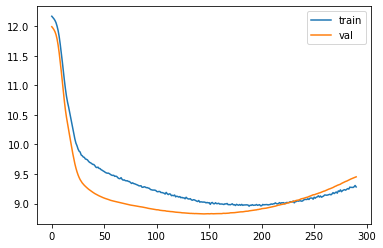

In [625]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

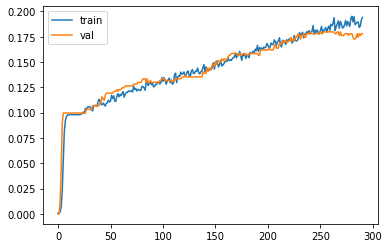

In [626]:
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [627]:
def build_dict():
    df = pd.read_csv('data/test.csv')
    dict_df = pd.DataFrame()
    answers = []
    indices = []
    for column in df.columns:
        answers.append(column)
        indices.append(df.columns.get_loc(column)-4)
    dict_df['answer'] = answers[4:]
    dict_df['index'] = indices[4:]
    dict_df.to_csv('data/dict.csv', index=False)

In [628]:
_, accuracy = evaluate(x_train, y_train, model_dir)
accuracy

158/158 [==============================] - 1s 8ms/step - loss: 8.9112 - categorical_accuracy: 0.1942


0.19418051838874817

In [629]:
test_df = pd.read_csv('data/test.csv')
dict_df = pd.read_csv('data/dict.csv')
f = open('data/train_original.json', "r")
answers_file = json.load(f)
f.close()

## NUMBERS

In [630]:
number_df = test_df[test_df.answer_type == 'number']
print(number_df.shape[0])

ty = []
for row in number_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, _ = build_model_input(number_df)
ty_pred = predict(tx, model_dir)
vqa_metric(ty, ty_pred)

5
1/1 [==============================] - 0s 58ms/step


0.06666666666666667

## YES/NO

In [631]:
yesno_df = test_df[test_df.answer_type == 'yes/no']
print(yesno_df.shape[0])

ty = []
for row in yesno_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, _ = build_model_input(yesno_df)
ty_pred = predict(tx, model_dir)
vqa_metric(ty, ty_pred)

49
2/2 [==============================] - 0s 8ms/step


0.5170068027210885

## OTHER

In [632]:
other_df = test_df[test_df.answer_type == 'other']
print(other_df.shape[0])

ty = []
for row in other_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, _ = build_model_input(other_df)
ty_pred = predict(tx, model_dir)
vqa_metric(ty, ty_pred)

568
18/18 [==============================] - 0s 8ms/step


0.2570422535211268

## TOTAL

In [633]:
ty = []
for row in test_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, _ = build_model_input(test_df)
ty_pred = predict(tx, model_dir)
vqa_metric(ty, ty_pred)

20/20 [==============================] - 0s 8ms/step


0.2767094017094017

## train + validation set training

In [645]:
train_df = pd.read_csv('data/train.csv')
x_train, y_train = build_model_input(train_df)
history = train2(x_train, y_train, 150, 'model2')

Model: "model_71"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_178 (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 input_177 (InputLayer)         [(None, 15, 512)]    0           []                               
                                                                                                  
 repeat_vector_88 (RepeatVector  (None, 15, 768)     0           ['input_178[0][0]']              
 )                                                                                                
                                                                                                  
 lambda_66 (Lambda)             (None, 15, 768)      0           ['input_177[0][0]',       

Epoch 40/150
57/57 - 3s - loss: 9.7050 - categorical_accuracy: 0.1117 - 3s/epoch - 55ms/step
Epoch 41/150
57/57 - 3s - loss: 9.6827 - categorical_accuracy: 0.1063 - 3s/epoch - 55ms/step
Epoch 42/150
57/57 - 3s - loss: 9.6680 - categorical_accuracy: 0.1056 - 3s/epoch - 57ms/step
Epoch 43/150
57/57 - 3s - loss: 9.6535 - categorical_accuracy: 0.1106 - 3s/epoch - 58ms/step
Epoch 44/150
57/57 - 3s - loss: 9.6266 - categorical_accuracy: 0.1088 - 3s/epoch - 57ms/step
Epoch 45/150
57/57 - 3s - loss: 9.6219 - categorical_accuracy: 0.1112 - 3s/epoch - 55ms/step
Epoch 46/150
57/57 - 3s - loss: 9.5913 - categorical_accuracy: 0.1095 - 3s/epoch - 57ms/step
Epoch 47/150
57/57 - 3s - loss: 9.5839 - categorical_accuracy: 0.1112 - 3s/epoch - 58ms/step
Epoch 48/150
57/57 - 3s - loss: 9.5757 - categorical_accuracy: 0.1101 - 3s/epoch - 59ms/step
Epoch 49/150
57/57 - 3s - loss: 9.5584 - categorical_accuracy: 0.1072 - 3s/epoch - 59ms/step
Epoch 50/150
57/57 - 3s - loss: 9.5444 - categorical_accuracy: 0.1131 

Epoch 128/150
57/57 - 3s - loss: 9.0468 - categorical_accuracy: 0.1347 - 3s/epoch - 55ms/step
Epoch 129/150
57/57 - 3s - loss: 9.0335 - categorical_accuracy: 0.1384 - 3s/epoch - 55ms/step
Epoch 130/150
57/57 - 3s - loss: 9.0264 - categorical_accuracy: 0.1397 - 3s/epoch - 56ms/step
Epoch 131/150
57/57 - 3s - loss: 9.0234 - categorical_accuracy: 0.1331 - 3s/epoch - 56ms/step
Epoch 132/150
57/57 - 3s - loss: 9.0170 - categorical_accuracy: 0.1397 - 3s/epoch - 55ms/step
Epoch 133/150
57/57 - 3s - loss: 9.0168 - categorical_accuracy: 0.1382 - 3s/epoch - 55ms/step
Epoch 134/150
57/57 - 3s - loss: 9.0147 - categorical_accuracy: 0.1405 - 3s/epoch - 55ms/step
Epoch 135/150
57/57 - 3s - loss: 9.0153 - categorical_accuracy: 0.1368 - 3s/epoch - 55ms/step
Epoch 136/150
57/57 - 3s - loss: 9.0115 - categorical_accuracy: 0.1393 - 3s/epoch - 55ms/step
Epoch 137/150
57/57 - 3s - loss: 9.0104 - categorical_accuracy: 0.1423 - 3s/epoch - 55ms/step
Epoch 138/150
57/57 - 3s - loss: 9.0064 - categorical_accura

## NUMBERS

In [646]:
ty = []
for row in number_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, _ = build_model_input(number_df)
ty_pred = predict(tx, 'model2')
vqa_metric(ty, ty_pred)

1/1 [==============================] - 0s 64ms/step


0.06666666666666667

## YES/NO

In [647]:
ty = []
for row in yesno_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, _ = build_model_input(yesno_df)
ty_pred = predict(tx, 'model2')
vqa_metric(ty, ty_pred)

2/2 [==============================] - 0s 8ms/step


0.2721088435374149

## OTHER

In [648]:
ty = []
for row in other_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, _ = build_model_input(other_df)
ty_pred = predict(tx, 'model2')
vqa_metric(ty, ty_pred)

18/18 [==============================] - 0s 8ms/step


0.21772300469483555

## TOTAL

In [649]:
ty = []
for row in test_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, _ = build_model_input(test_df)
ty_pred = predict(tx, 'model2')
vqa_metric(ty, ty_pred)

20/20 [==============================] - 0s 8ms/step


0.220619658119658